In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

# One-tailed or two-tailed test, that is the question

Learn the difference between two variants of statistical tests and how to implement them in Python!

## Introduction

In data science/econometrics we see statistical tests in many places: correlation analysis, ANOVA, A/B testing, linear regression results, etc. Therefore, for the practitioners, it is very important to thoroughly understand their meaning and know why a given test was used in a particular place. In this article, I would like to provide some intuition for picking an appropriate version of a statistical test - one-tailed or two-tailed - that fits the stated hypotheses.

The crucial step in conducting any statistical testing is choosing the right hypotheses, as they not only determine the kind of statistical test that should be used but also influence the version of it.

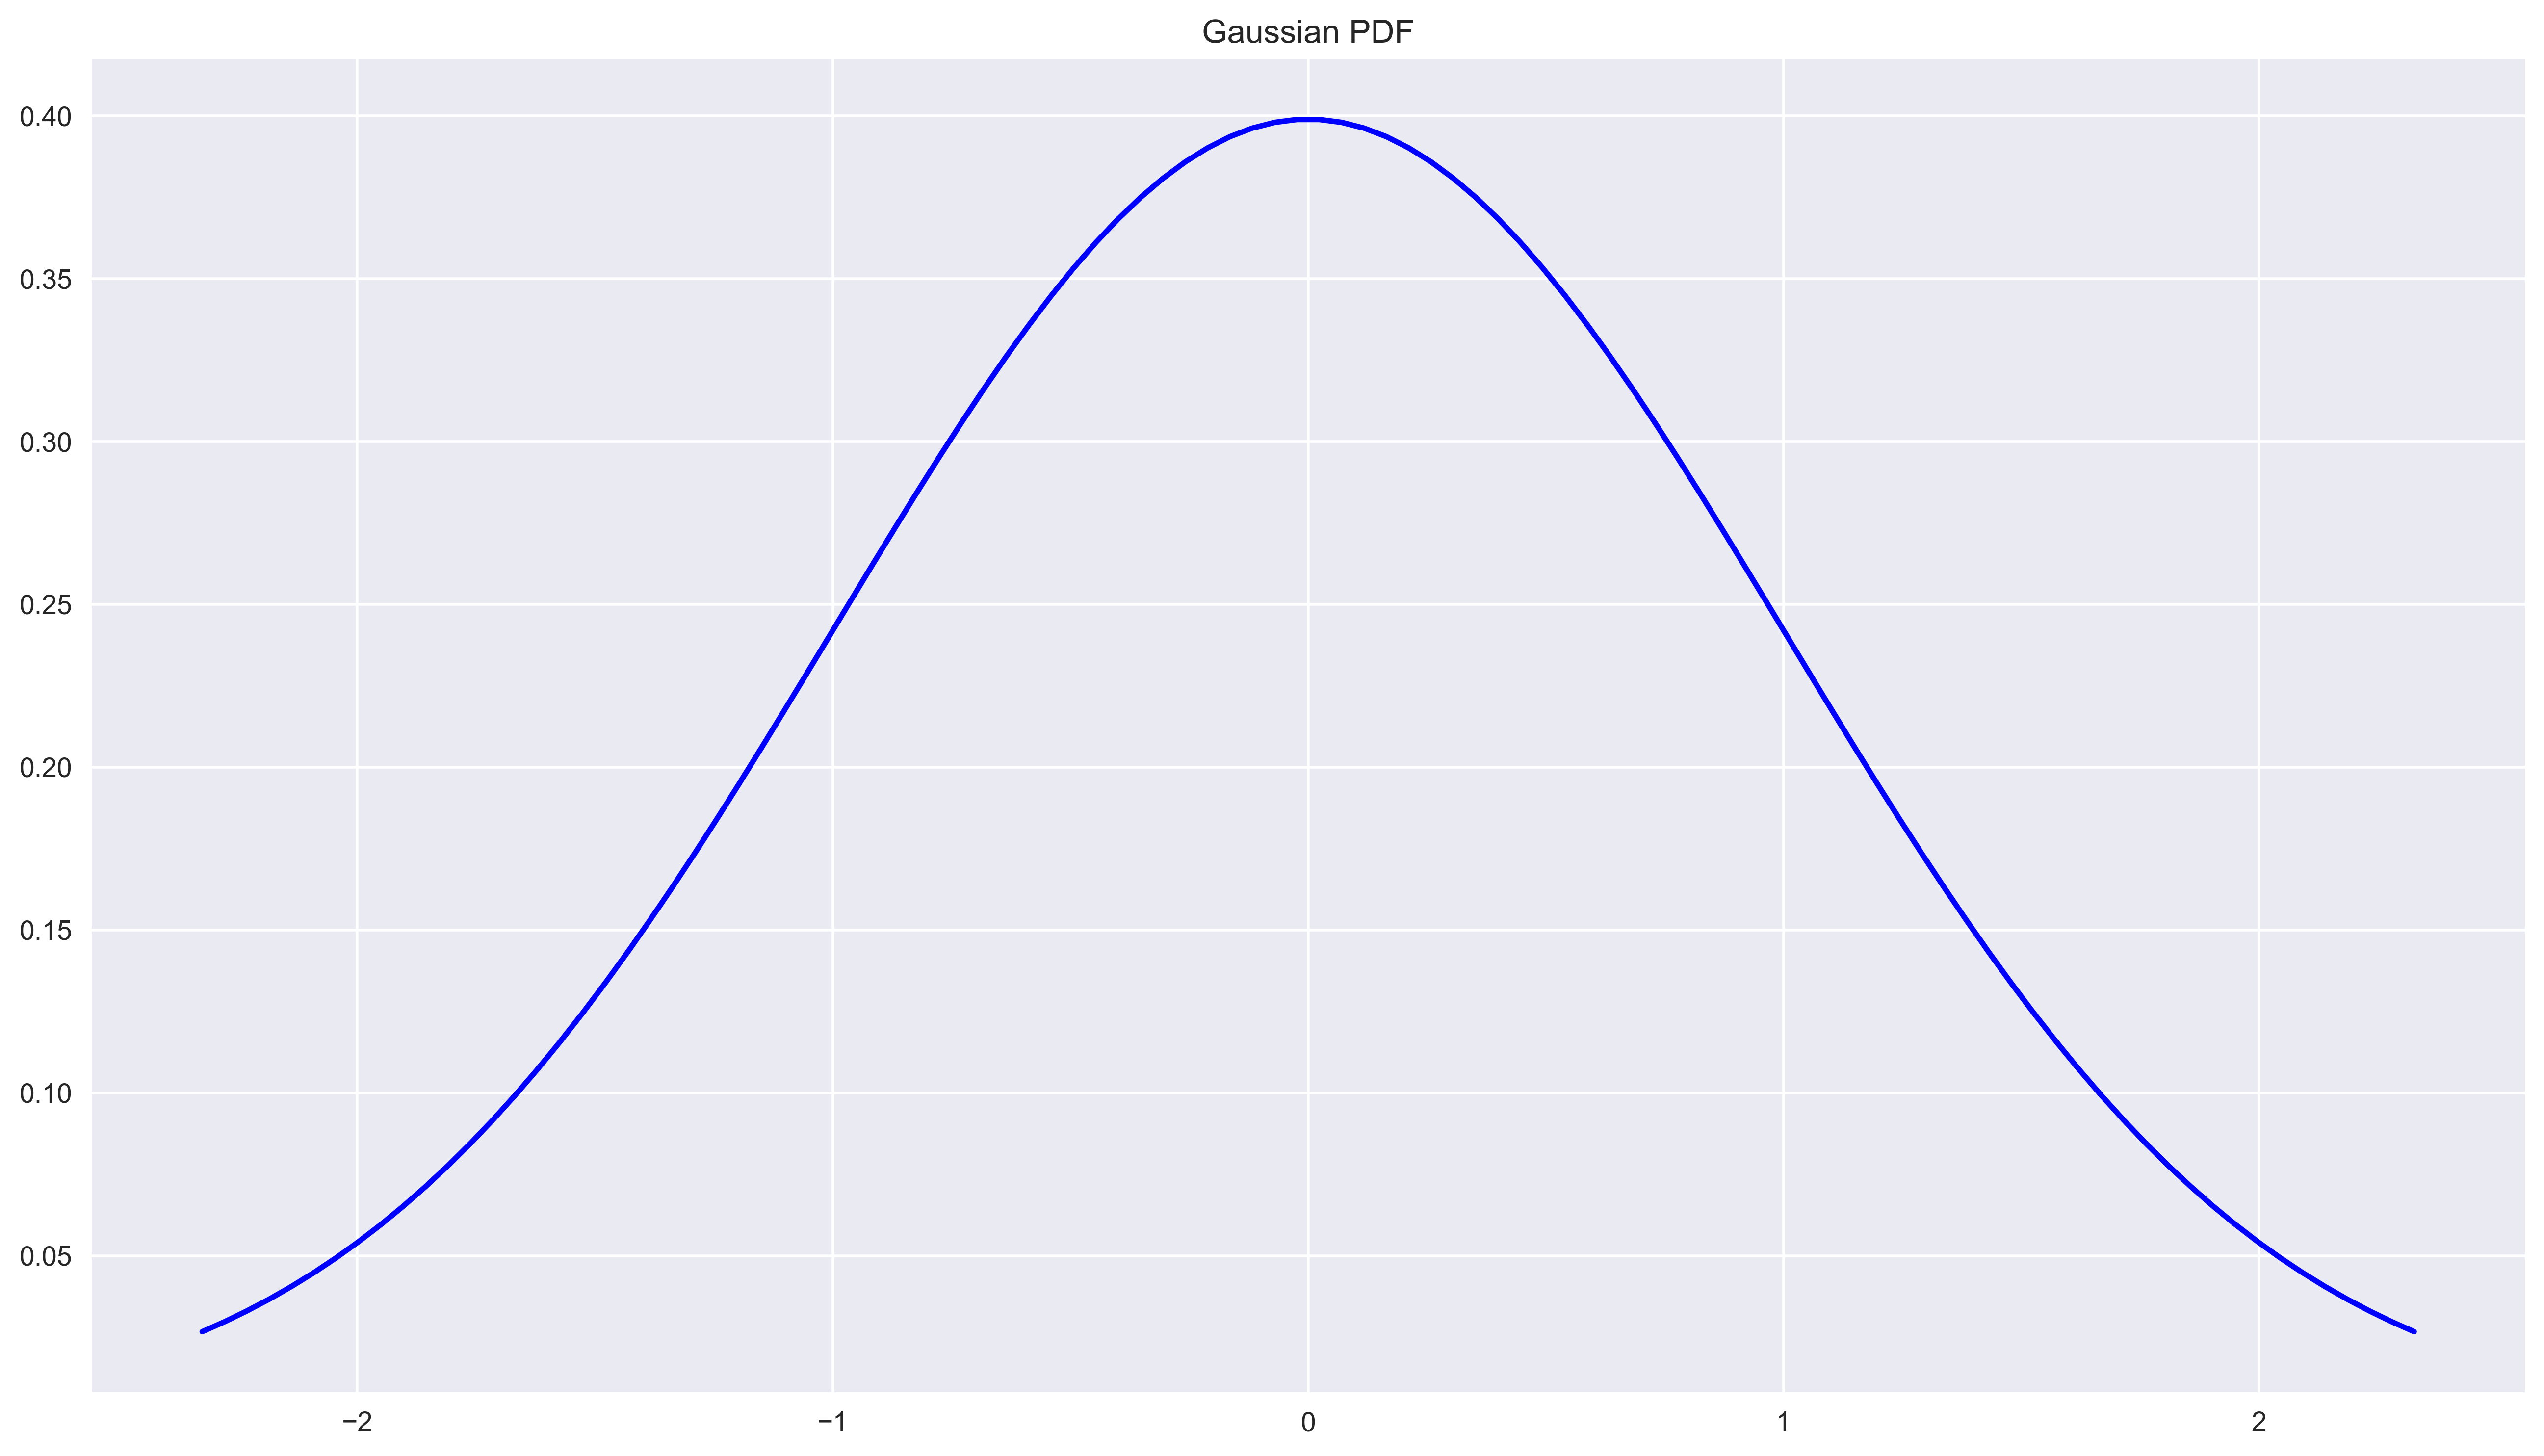

In [3]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)

rv = norm()
ax.plot(x, rv.pdf(x), 'b-', lw=2)
ax.set_title('Gaussian PDF');

In case the considered test statistic is symmetrically distributed, we can select one of three alternative hypotheses:
* x is greater than y
* x is smaller than y
* x is not equal to y

The first two correspond to one-tailed tests, while the last one corresponds to a two-tailed test.  

Let's dive deeper into investigating the differences between the two variants of a test and show some examples in Python!

## One-tailed test

Let's assume we have selected 0.05 (or 5%) as our significance level. Working with a one-tailed test means that the critical region is located in the top/bottom 5% of the test statistic's probability distribution. If the test statistic falls into this region, we reject the null hypothesis. We are effectively testing the possibility of the relationship in one direction (significantly greater OR less) and disregarding the possibility of a relationship in the other direction.

An important characteristic of the one-tailed test is that it provides more power to detect an effect in one direction, as it does not test the other one. However, this also poses some threats, which I illustrate in the following example.

Let's imagine that we manufactured a new drug and want to test its effectiveness against the current solution. We may be tempted to use the one-tailed test, as it maximizes the chances of detecting the improvement (clearly specified direction of effect). But this exposes us to the possibility of missing the fact that our drug is actually less effective than the current one.

This example shows that we should select the one-tailed test when the consequences of missing an effect are negligible, so not like in the example above!. We should never select the one-tailed test for the sole purpose of obtaining statistical significance, as this can lead to an invalid conclusion and in some cases dire consequences.

## Two-tailed test

In the case of the two-tailed tests, we are testing a hypothesis that does not include a directional relationship.  If we wanted to test whether the sample mean is equal to x (null hypothesis of a t-test), then the alternative one states that the mean is not equal to x. To test it, we consider the case of the mean being significantly greater AND significantly less than x. With a 5% significance level, the sample mean is considered significantly different from x when the test statistic falls into the critical region - the bottom AND top 2.5% of the test statistic's probability distribution. This results in a p-value of less than 0.05 and indicates we should reject the null hypothesis in favor of the alternative one.

## Example in Python

Let's assume that we are working with data regarding school exams. Students from two schools wrote the same standardized exam and now we would like to investigate if there is a statistical difference between the average results.

For simplicity, we assume that the schools have 100 students each and the scores from the exams come from Gaussian distribution with different parameters.

### Generate data

In [4]:
# import libraries
import numpy as np
from scipy import stats
import seaborn as sns

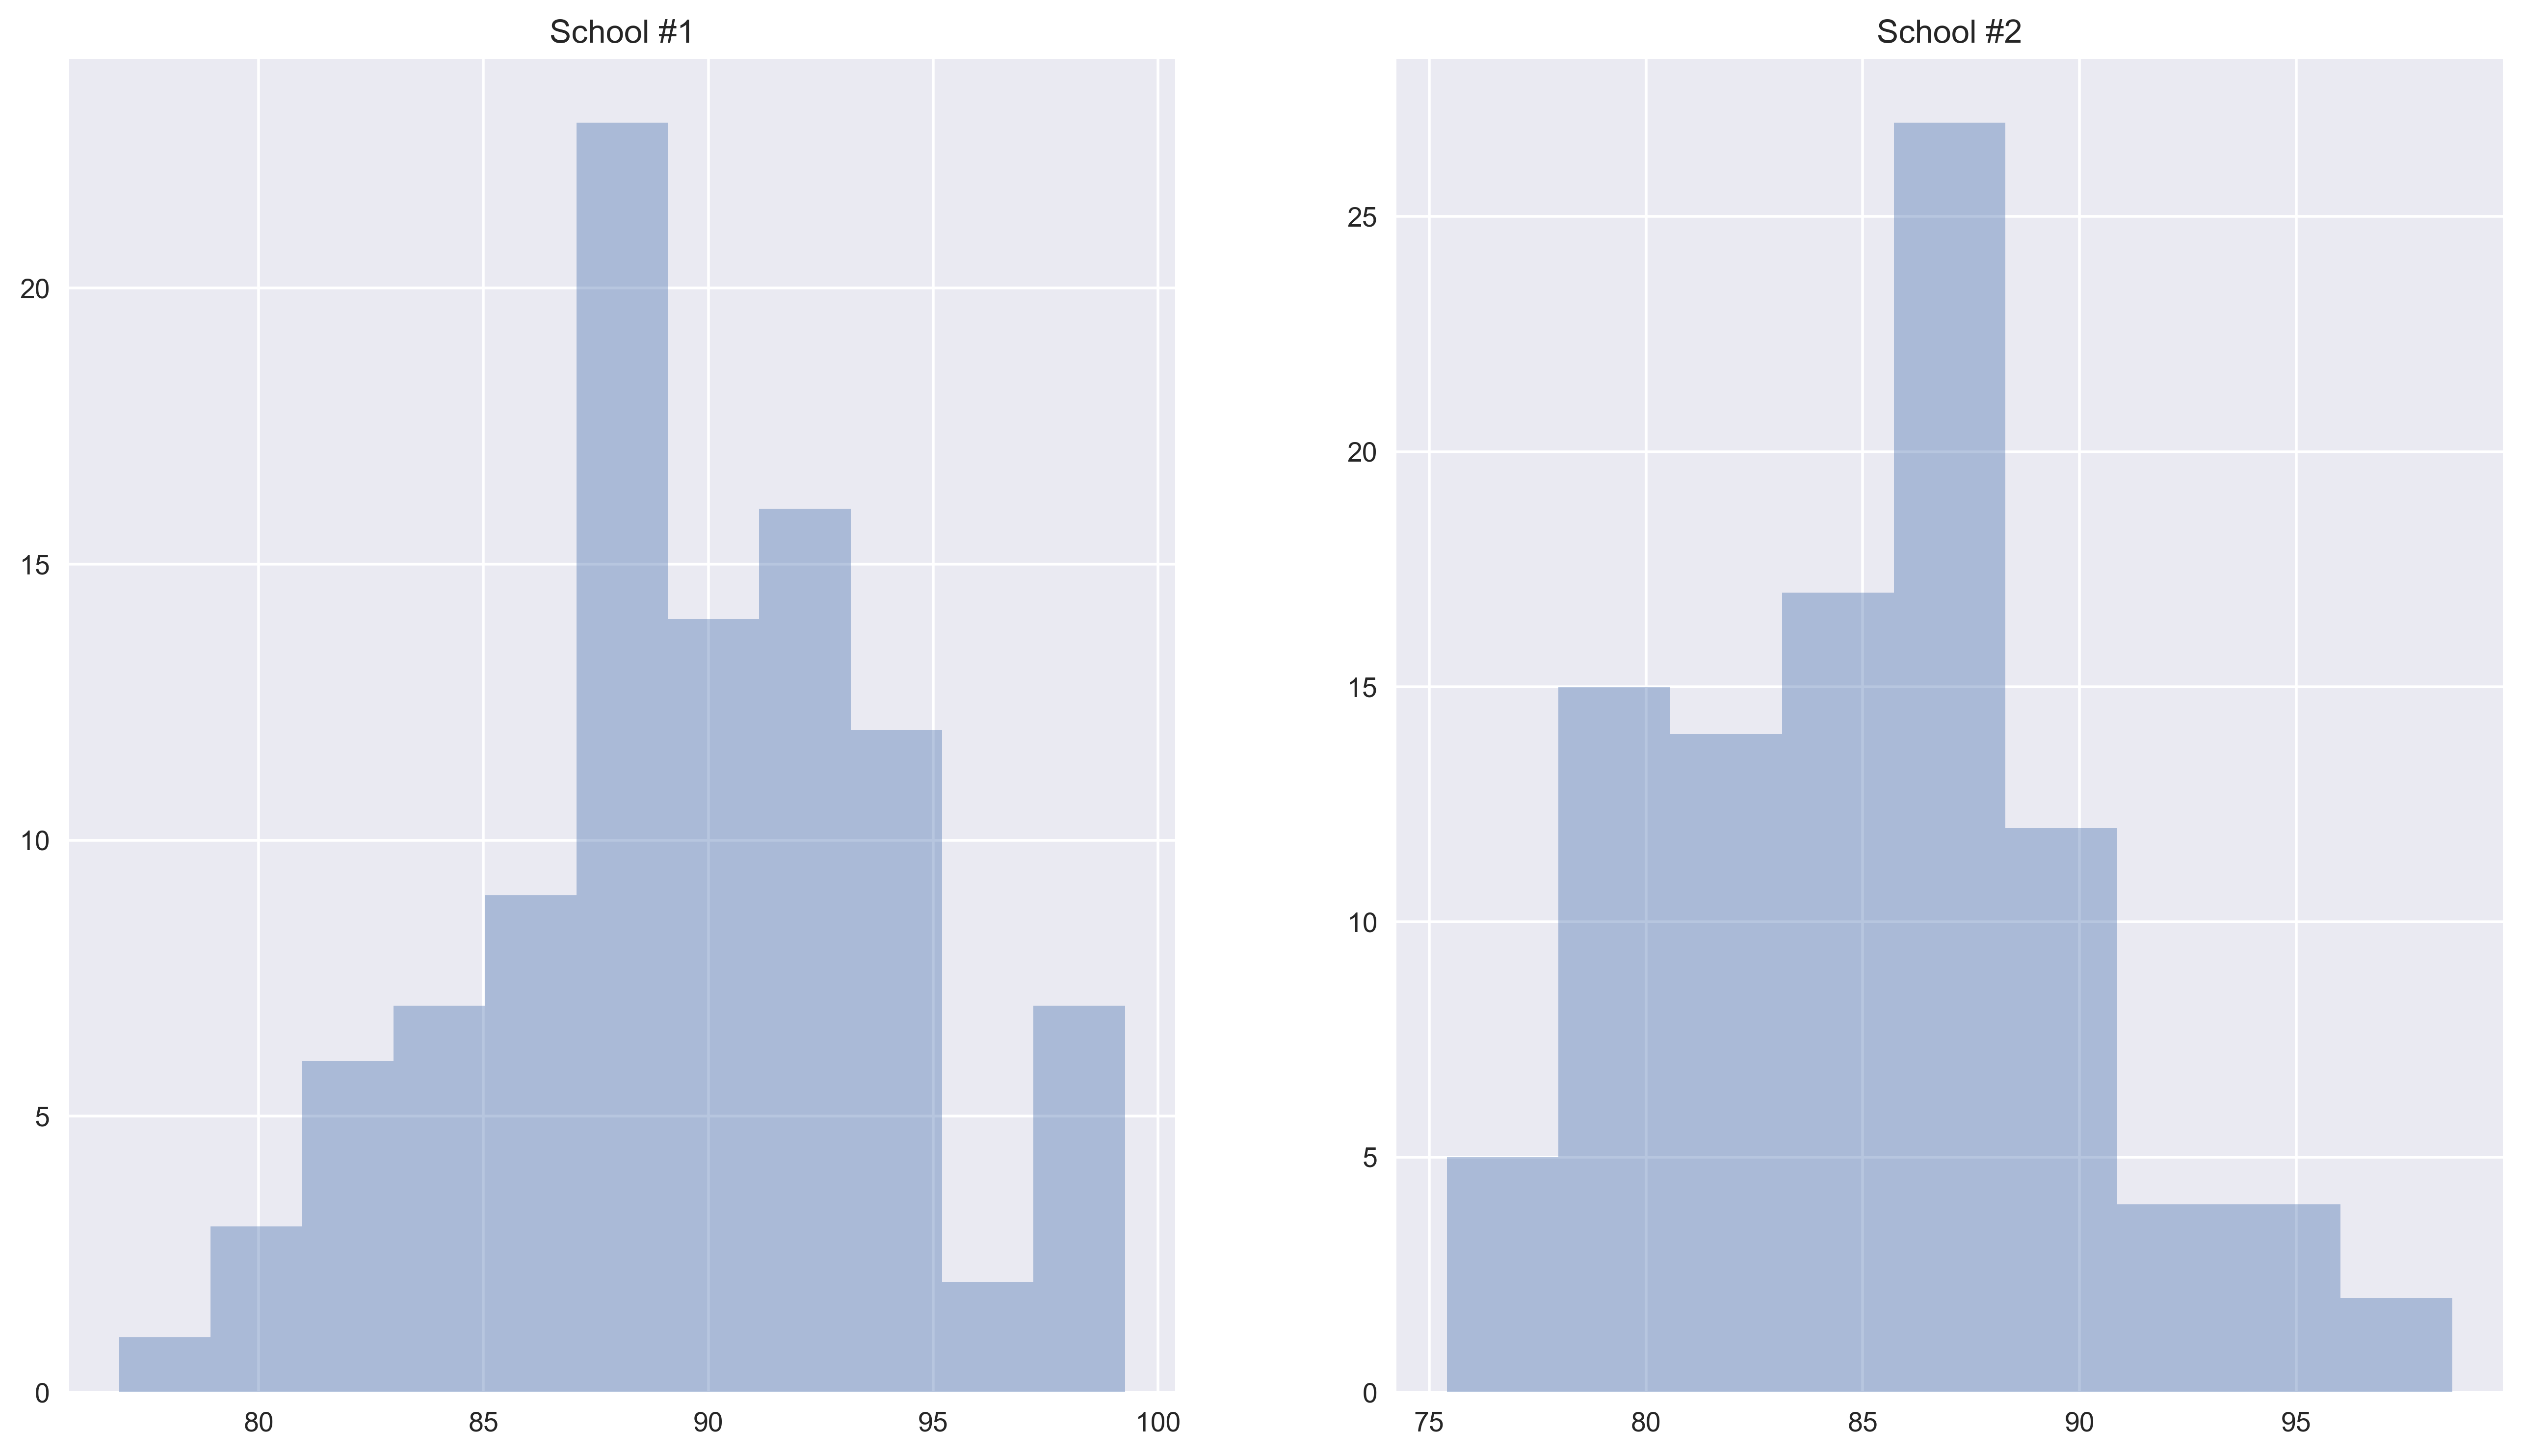

In [14]:
# set seed for reproducibility
np.random.seed(42)

# define sample size
n = 100

# generate two samples
school_1 = np.random.normal(loc=90, scale=5, size=n)
school_2 = np.random.normal(loc=85, scale=5, size=n)

# plot samples 

fig, ax = plt.subplots(1, 2)

sns.distplot(school_1, kde=False, ax=ax[0])
ax[0].set_title('School #1')


sns.distplot(school_2, kde=False, ax=ax[1])
ax[1].set_title('School #2')

plt.show()

### One-sample t-test

In the one-sample t-test, we test the mean of a sample against a particular value. We start with the two-tailed variant of the test, with the following hypotheses:

* H_0: the mean result of students from school #1 is 70
* H_1: the mean result of students from school #1 is not 70

In [8]:
test_1 = stats.ttest_1samp(school_1, 70)
test_1

Ttest_1sampResult(statistic=42.90122143039788, pvalue=9.063698741097363e-66)

The p-value of the test is below 0.05, so we can reject the null hypothesis in favor of the alternative one. 

In the second test, we check if the mean result of students from school #2 is greater than 90. 

* H_0: the mean result of students in school #2 is greater or equal to 90
* H_1: the mean result of students in school #2 is less than 90

As this is a directional test, we are doing a one-tailed variant of the t-test.

In [9]:
test_2 = stats.ttest_1samp(school_2, 90)
test_2

Ttest_1sampResult(statistic=-10.251936967846719, pvalue=3.087893244277984e-17)

In `scipy` there is no direct way to indicate that we want to run a one-tailed variant of the test. However, to obtain the desired results we adjust the output ourselves. In the case of this setting, we simply need to divide the p-value by 2 (the test statistic stays the same).

In [10]:
test_2.pvalue / 2

1.543946622138992e-17

With the obtained `p-value < 0.05` we have reasons to reject the null hypothesis in favor of the alternative.

To be thorough, we also run the last variant of the test.

* H_0: the mean result of students in school #2 is less or equal to 90
* H_1: the mean result of students in school #2 is greater than 90

In [11]:
test_3 = stats.ttest_1samp(school_2, 90)
test_3

Ttest_1sampResult(statistic=-10.251936967846719, pvalue=3.087893244277984e-17)

We also need to correct the p-value, this time in a slightly different way:

In [12]:
1 - test_3.pvalue / 2

1.0

With the obtained `p-value = 1` we have no reason to reject the null hypothesis. The way of correcting the p-value depends on the alternative hypothesis we consider, whether it concerns a test for being 'greater' or 'less'.

### Two-sample t-test

In the two-sample test, we test the equality of two sample means against each other.

* H_0: the mean result of students from school #1 is the same as the mean result from school #2
* H_1: the mean result of students from school #1 and #2 are not equal

By default, `stats.ttest_ind` assumes that the populations have identical variances (which is true in this case, see data generation).

In [13]:
test_4 = stats.ttest_ind(school_1, school_2)
test_4

Ttest_indResult(statistic=6.635596055724986, pvalue=3.0230309820272883e-10)

The results indicate that we should reject the null hypothesis about equal average results in the two schools, which is in line with the expectations.

To keep the article brief we only consider the two-tailed variant of the test, as the one-tailed calculations are analogous to the code above.

## Conclusions

In this article, I presented some intuition about the one- and two-tailed variants of statistical tests. By default, most statistical software produces two-tailed results. That is why it is also important to be able to convert these results into the one-tailed equivalents.

If you liked the topic of this article, you might also be interested in the one describing [power analysis](https://towardsdatascience.com/introduction-to-power-analysis-in-python-e7b748dfa26).

As always, any constructive feedback is welcome. You can reach out to me on [Twitter](https://twitter.com/erykml1) or in the comments. The code for the article can be found here.